In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint
from matplotlib import pyplot as plt


In [2]:
# load data
df = pd.read_csv("dataset/steel_strength.csv")
# get dependent and independent features
X=df.iloc[:,1:-3]
y=df.iloc[:,-2]

y_full_mask = ~np.isnan(y)
X=X[y_full_mask]
y=y[y_full_mask]

In [3]:
from sklearn.model_selection import RandomizedSearchCV
from common import XGB_search_params
from xgboost import XGBRegressor

r2_scoring = metrics.make_scorer(metrics.r2_score)

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBRegressor(device='cpu',max_bin=1024)

params = XGB_search_params()
state = randint(0,100)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=1000,
    cv=5,
    random_state=state,
    n_jobs=-1,
    scoring=r2_scoring
)
search.fit(X,y)
special_model=search.best_estimator_

In [4]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold, cross_val_score
def cross_val_score_mean_std(scores,name):
    print(f"-----------{name}-----------")
    print("Mean ",np.mean(scores))
    print("Std ",np.std(scores))

special_model.device='cpu'
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=50)

print("r2 scoring")
cross_val_score_mean_std(cross_val_score(special_model,X,y,cv=cv,scoring=r2_scoring),y.name)

r2 scoring
-----------tensile strength-----------
Mean  0.8492436833967782
Std  0.05392269939994976


In [13]:
X_cleaned=X.to_numpy()
y_cleaned=y

total error  0.8738427417423973


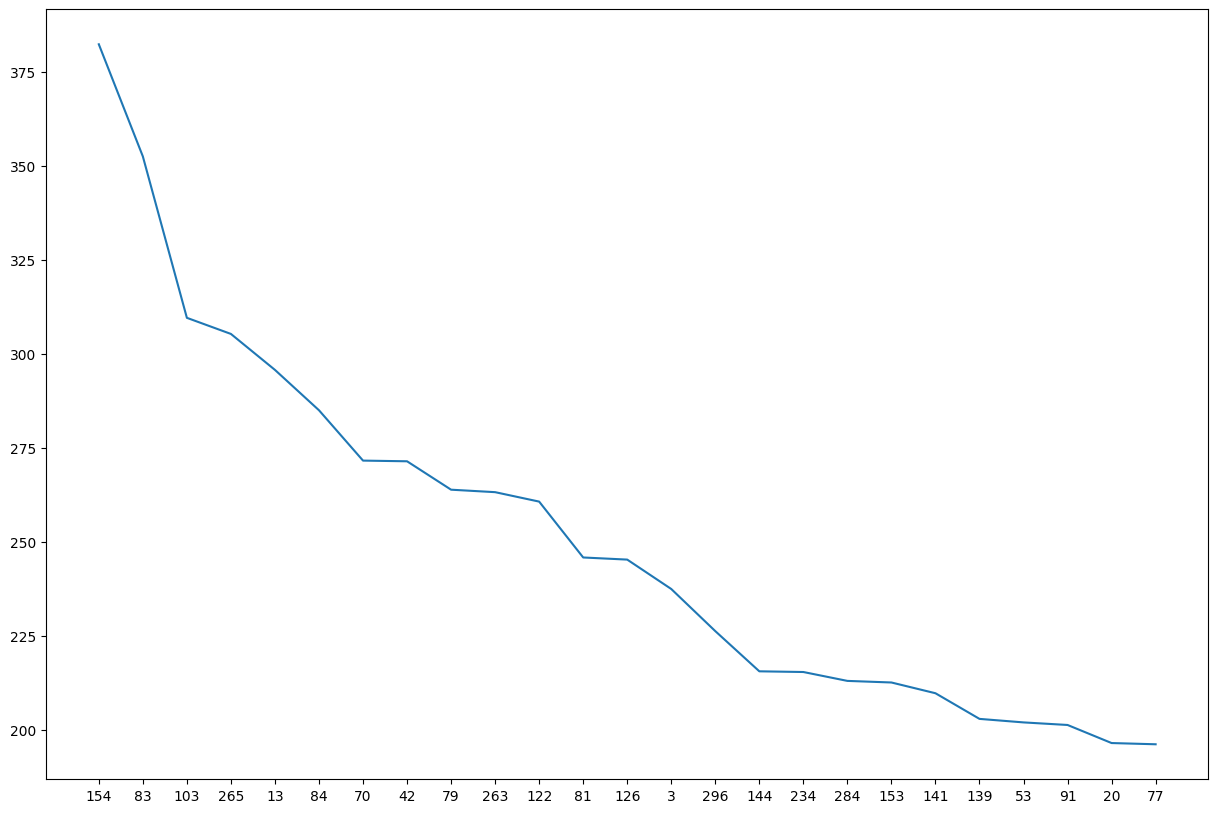

In [15]:
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from common import run_iteration

indices_to_remove=[]
indices_to_remove=[107,311,100,178,155,260,64,48,110]
X_cleaned = [row for i,row in enumerate(X_cleaned) if i not in indices_to_remove]
y_cleaned = [row for i,row in enumerate(y_cleaned) if i not in indices_to_remove]

X_cleaned=np.array(X_cleaned)
y_cleaned=np.array(y_cleaned)

pred, total = run_iteration(
    X=X_cleaned,
    y=y_cleaned,
    model=special_model,
    pred_scoring=metrics.mean_absolute_error,
    evaluate_scoring=metrics.r2_score,
    cv=5,
    repeats=10,
    seed=randint(0,100))
print("total error ",total)
indices = np.argsort(-pred)
indices=indices[:25]
x=np.arange(0,len(indices))
plt.figure(figsize=(15,10))
plt.plot(x,pred[indices])
plt.xticks(x,labels=indices)
plt.show()